`06_corr`
# Correlation (상관관계) 🔗🤝↔️

## 정의
- 두 변수 간에 서로 얼마나 함께 변하는 지 정도를 나타내는 통계 개념
- 값의 범위는 : -1 ~ +1
    - +1: 완벽한 양의 상관관계 -> x가 증가하면 y도 비례해서 증가 (ex. 키 - 몸무게)
    - 0: 상관없음 (ex. 키 - 수학점수)
    - -1: 완벽한 음의 상관관계 -> x가 증가하면 y가 비례해서 감소 (ex. 운동량 - 체지방률)

## 상관 계수 ($r$)
두 변수 간의 관계가 얼마나 강한 지 측정하는 법
- 피어슨 (Pearson) : 가장 많이 쓰임. 연속 변수 선형 관계 측정
- 스피어맨 (Spearman) : 순위(랭크) 기반, 비선형 관계, 이상치에 강함
- 켄달 (Kendall) : 순위 일관성 기반. 표본이 적을 때 안정적

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


df = pd.read_csv('./OnlineRetail.csv', encoding='ISO-8859-1')

In [2]:
from da_utils import profile, outliers, patterns

# 데이터 프로파일링
profile.get_data_profile(df)

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 541909행 x 8열
- 메모리 사용량: 173.12mb
- 수치형 변수: 3개
- 범주형 변수: 5개

2. 결측값 분석
⚠️


,결측수,결측율(%)
Description,1454,0.27
CustomerID,135080,24.93



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,Quantity,9.552,218.081,-80995.00,80995.0,-0.264,119769.160,10.817,0.133
1,UnitPrice,4.611,96.760,-11062.06,38970.0,186.507,59005.719,7.312,0.301
2,CustomerID,15287.691,1713.600,12346.00,18287.0,0.030,-1.180,0.000,1.075



4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️
-- UnitPrice: 왜도 = 186.507

- 높은 이상값 비율(>5%)
⚠️
-- Quantity: 이상값 10.8%
-- UnitPrice: 이상값 7.3%


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,Quantity,9.552,218.081,-80995.00,80995.0,-0.264,119769.160,10.817,0.133
1,UnitPrice,4.611,96.760,-11062.06,38970.0,186.507,59005.719,7.312,0.301
2,CustomerID,15287.691,1713.600,12346.00,18287.0,0.030,-1.180,0.000,1.075


=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
CustomerID,135080,24.93
Description,1454,0.27


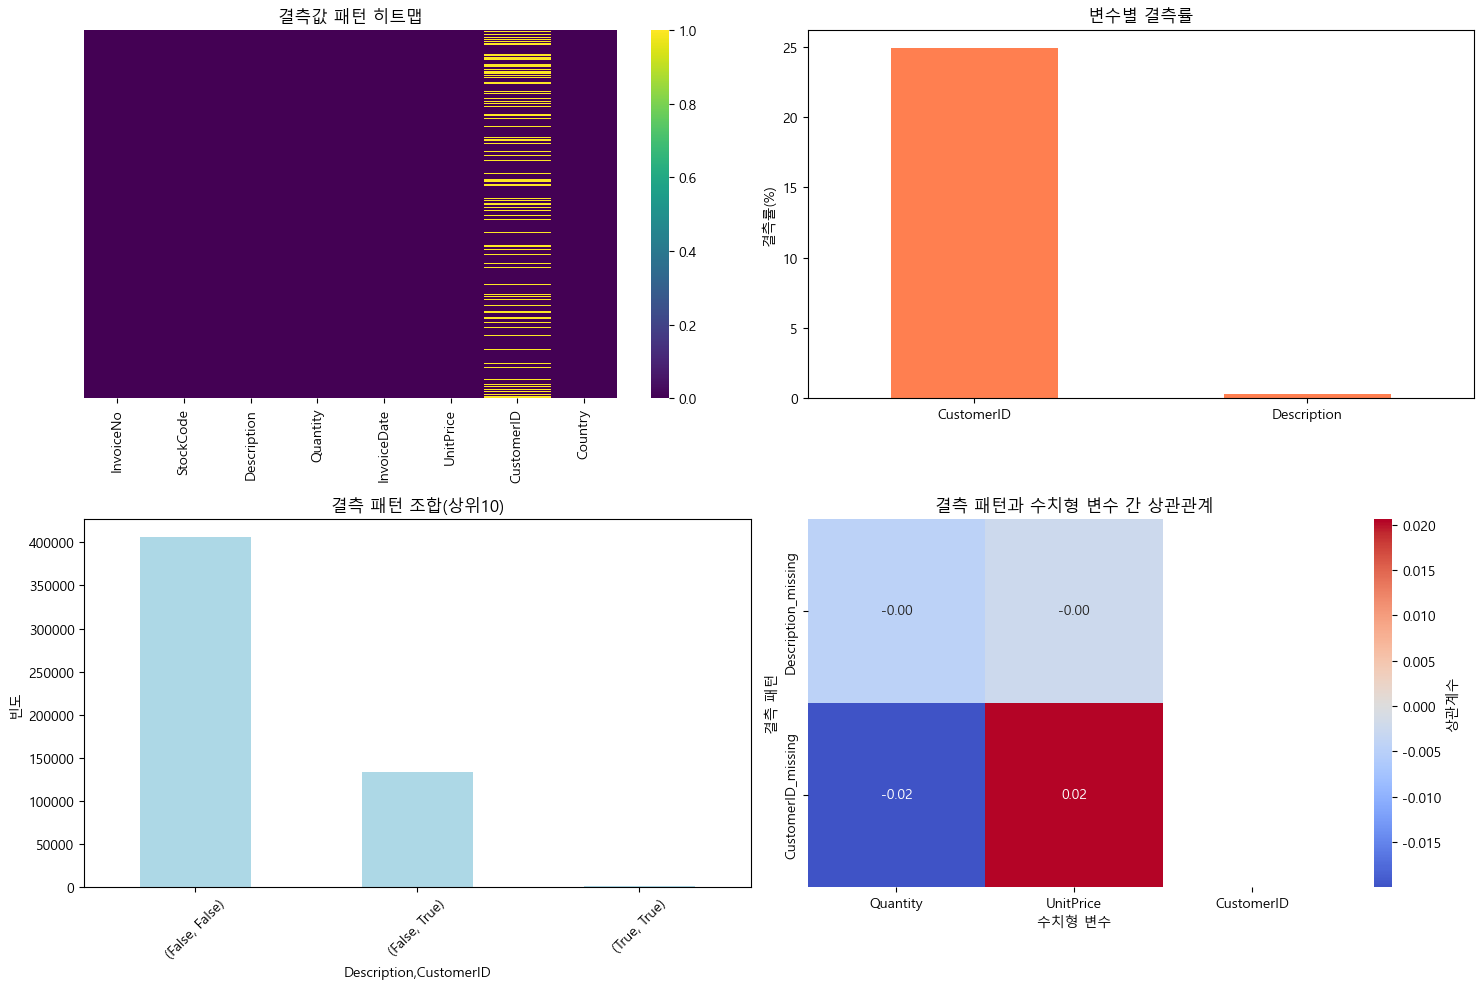

,결측수,결측률(%)
CustomerID,135080,24.93
Description,1454,0.27


In [3]:
# 결측치 모니터링 함수
patterns.analyze_missing_patterns(df)

In [4]:
# 이상치 탐지 함수 (결측치 처리 후 실행 필요)
outliers.outlier_detection(df, 0.999, iso_cont='auto', final_threshold=2)

결측치 확인. 처리 후 재시도 하세요


In [5]:
print('전체 거래', len(df))
print('고유 InvoiceNo', df['InvoiceNo'].nunique())
print('고유 고객수', df['CustomerID'].nunique())

전체 거래 541909
고유 InvoiceNo 25900
고유 고객수 4372


In [ ]:
# 데이터 전처리
df_clean = df.copy()

# CustomerID 결측값 제거 (고객 단위 분석을 위해 필수)
missing_customers = df_clean['CustomerID'].isnull().sum()
print(f'CustomerID 결측값 제거: {missing_customers}건')
df_clean = df_clean.dropna(subset=['CustomerID'])

# 취소 거래 분리 (InvoiceNo 가 'C' 로 시작)
cancel_mask = df_clean['InvoiceNo'].astype('str').str.startswith('C')
# 취소 거래, 정상 거래 분리
df_cancel = df_clean[cancel_mask]
df_clean = df_clean[~cancel_mask]
print(f'취소 거래 분리: {len(df_cancel)}건')
print(f'정상 거래 분리: {len(df_clean)}건')

# df_clean에 파생 변수 생성 (상관 관계 분석)
# TotalAmount, InvoiceDate(DateTime), Year, Month, DayOfWeek(숫자), Hour, DayName(글자), CustomerID(Str)
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int).astype(str)
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['DayName'] = df_clean['InvoiceDate'].dt.day_name()

print('\n=== 이상값 확인 ===')
print(f'음수 수량: {(df_clean['Quantity'] < 0).sum()}')
print(f'음수 단가: {(df_clean['UnitPrice'] < 0).sum()}')
print(f'0 단가: {(df_clean['UnitPrice'] == 0).sum()}')

# 양수 수량 & 양수 단가 데이터만 살리기
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

CustomerID 결측값 제거: 135080건
취소 거래 분리: 8905건
정상 거래 분리: 397924건

=== 이상값 확인 ===
음수 수량: 0
음수 단가: 0
0 단가: 40


In [ ]:
print('=== 고객별 구매 패턴 특성 DF 생성 ===')

customer_stats = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'count',  # 구매 횟수(Frequency)
    'Quantity': ['sum', 'mean'],  # 총 구매량, 평균 구매량
    'UnitPrice': 'mean',  # 평균 단가
    'TotalAmount': ['sum', 'mean'],  # 총 구매액(Monetary), 평균 구매액
    'StockCode': 'nunique',  # 구매한 상품 종류 수
    'InvoiceDate': ['min', 'max']  # 첫 구매일, 마지막 구매일
}).round(2)

# 컬럼명 정리 (구매횟수==F, 총구매액==M)
customer_stats.columns = ['Frequency', '총구매량', '평균구매량', '평균단가', 
                        'Monetary', '평균구매액', '상품종류수', '첫구매일', '마지막구매일']

# 구매 기간 및 주기 계산 (추가하기)
customer_stats['구매기간일수'] = (customer_stats['마지막구매일'] - customer_stats['첫구매일']).dt.days + 1
customer_stats['구매주기'] = (customer_stats['구매기간일수'] / customer_stats['Frequency']).round(2)

# RFM 분석 변수
analysis_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
customer_stats['Recency'] = (analysis_date - customer_stats['마지막구매일']).dt.days

# RFM점수 (모두 5등급) (.qcut으로 5등분)
customer_stats['R_score'] = pd.qcut(customer_stats['Recency'], 5, labels=[5, 4, 3, 2, 1])
customer_stats['F_score'] = pd.qcut(customer_stats['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
customer_stats['M_score'] = pd.qcut(customer_stats['Monetary'], 5, labels=[1, 2, 3, 4, 5])
customer_stats['RFM_score'] = customer_stats['R_score'].astype(str) + customer_stats['F_score'].astype(str) + customer_stats['M_score'].astype(str)
# 추가정보
customer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['Frequency']
customer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['Frequency']

# 가격 민감도 - 단가가 상대적으로 일관되게 유지되는가?
# CV = Coefficient of Variation (표준편차 / 평균) => 높으면, 다양한 가격대로 산다 / 낮으면, 특정 가격대에 고정적 구매
price_cv = df_clean.groupby('CustomerID')['UnitPrice'].agg(['mean', 'std'])
price_cv['가격변동성'] = (price_cv['std'] / price_cv['mean']).fillna(0)

customer_stats = customer_stats.merge(
    price_cv[['가격변동성']],  # 두 DF 다 컬럼이 아닌 인덱스가 CustomerID
    left_index=True,  # customer_stats의 인덱스 기준으로 병합
    right_index=True  # price_cv의 인덱스 기준으로 병합
)

customer_stats

=== 고객별 구매 패턴 특성 DF 생성 ===


,Frequency,총구매량,평균구매량,평균단가,Monetary,평균구매액,상품종류수,첫구매일,마지막구매일,구매기간일수,구매주기,Recency,R_score,F_score,M_score,RFM_score,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1.00,326,1,1,5,115,74215.000000,1.000000,0.000000
12347,182,2458,13.51,2.64,4310.00,23.68,103,2010-12-07 14:57:00,2011-12-07 15:52:00,366,2.01,2,5,5,5,555,13.505495,0.565934,0.853015
12348,31,2341,75.52,5.76,1797.24,57.98,22,2010-12-16 19:09:00,2011-09-25 13:13:00,283,9.13,75,2,3,4,234,75.516129,0.709677,2.324492
12349,73,631,8.64,8.29,1757.55,24.08,73,2011-11-21 09:51:00,2011-11-21 09:51:00,1,0.01,19,4,4,4,444,8.643836,1.000000,4.225823
12350,17,197,11.59,3.84,334.40,19.67,17,2011-02-02 16:01:00,2011-02-02 16:01:00,1,0.06,310,1,2,2,122,11.588235,1.000000,2.430180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,10,45,4.50,4.76,180.60,18.06,10,2011-03-07 09:52:00,2011-03-07 09:52:00,1,0.10,278,1,1,1,111,4.500000,1.000000,0.518798
18281,7,54,7.71,5.62,80.82,11.55,7,2011-06-12 10:53:00,2011-06-12 10:53:00,1,0.14,181,1,1,1,111,7.714286,1.000000,1.383397
18282,12,103,8.58,5.20,178.05,14.84,12,2011-08-05 13:35:00,2011-12-02 11:43:00,119,9.92,8,5,1,1,511,8.583333,1.000000,0.937819


In [50]:
print('=== 기본 상관관계 분석 ===')

# 수치형 상관관계 분석용
numeric_cols =  ['Frequency', '총구매량', '평균구매량', '평균단가', 'Monetary', 
                   '평균구매액', '상품종류수', '구매기간일수', '구매주기', 'Recency', 
                   'Frequency', 'Monetary', '평균장바구니크기', '거래당상품종류', '가격변동성']

correlation_data = customer_stats[numeric_cols]
correlation_data.head(3)

=== 기본 상관관계 분석 ===


,Frequency,총구매량,평균구매량,평균단가,Monetary,평균구매액,상품종류수,구매기간일수,구매주기,Recency,Frequency,Monetary,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,1,1.00,326,1,77183.60,74215.000000,1.000000,0.000000
12347,182,2458,13.51,2.64,4310.00,23.68,103,366,2.01,2,182,4310.00,13.505495,0.565934,0.853015
12348,31,2341,75.52,5.76,1797.24,57.98,22,283,9.13,75,31,1797.24,75.516129,0.709677,2.324492


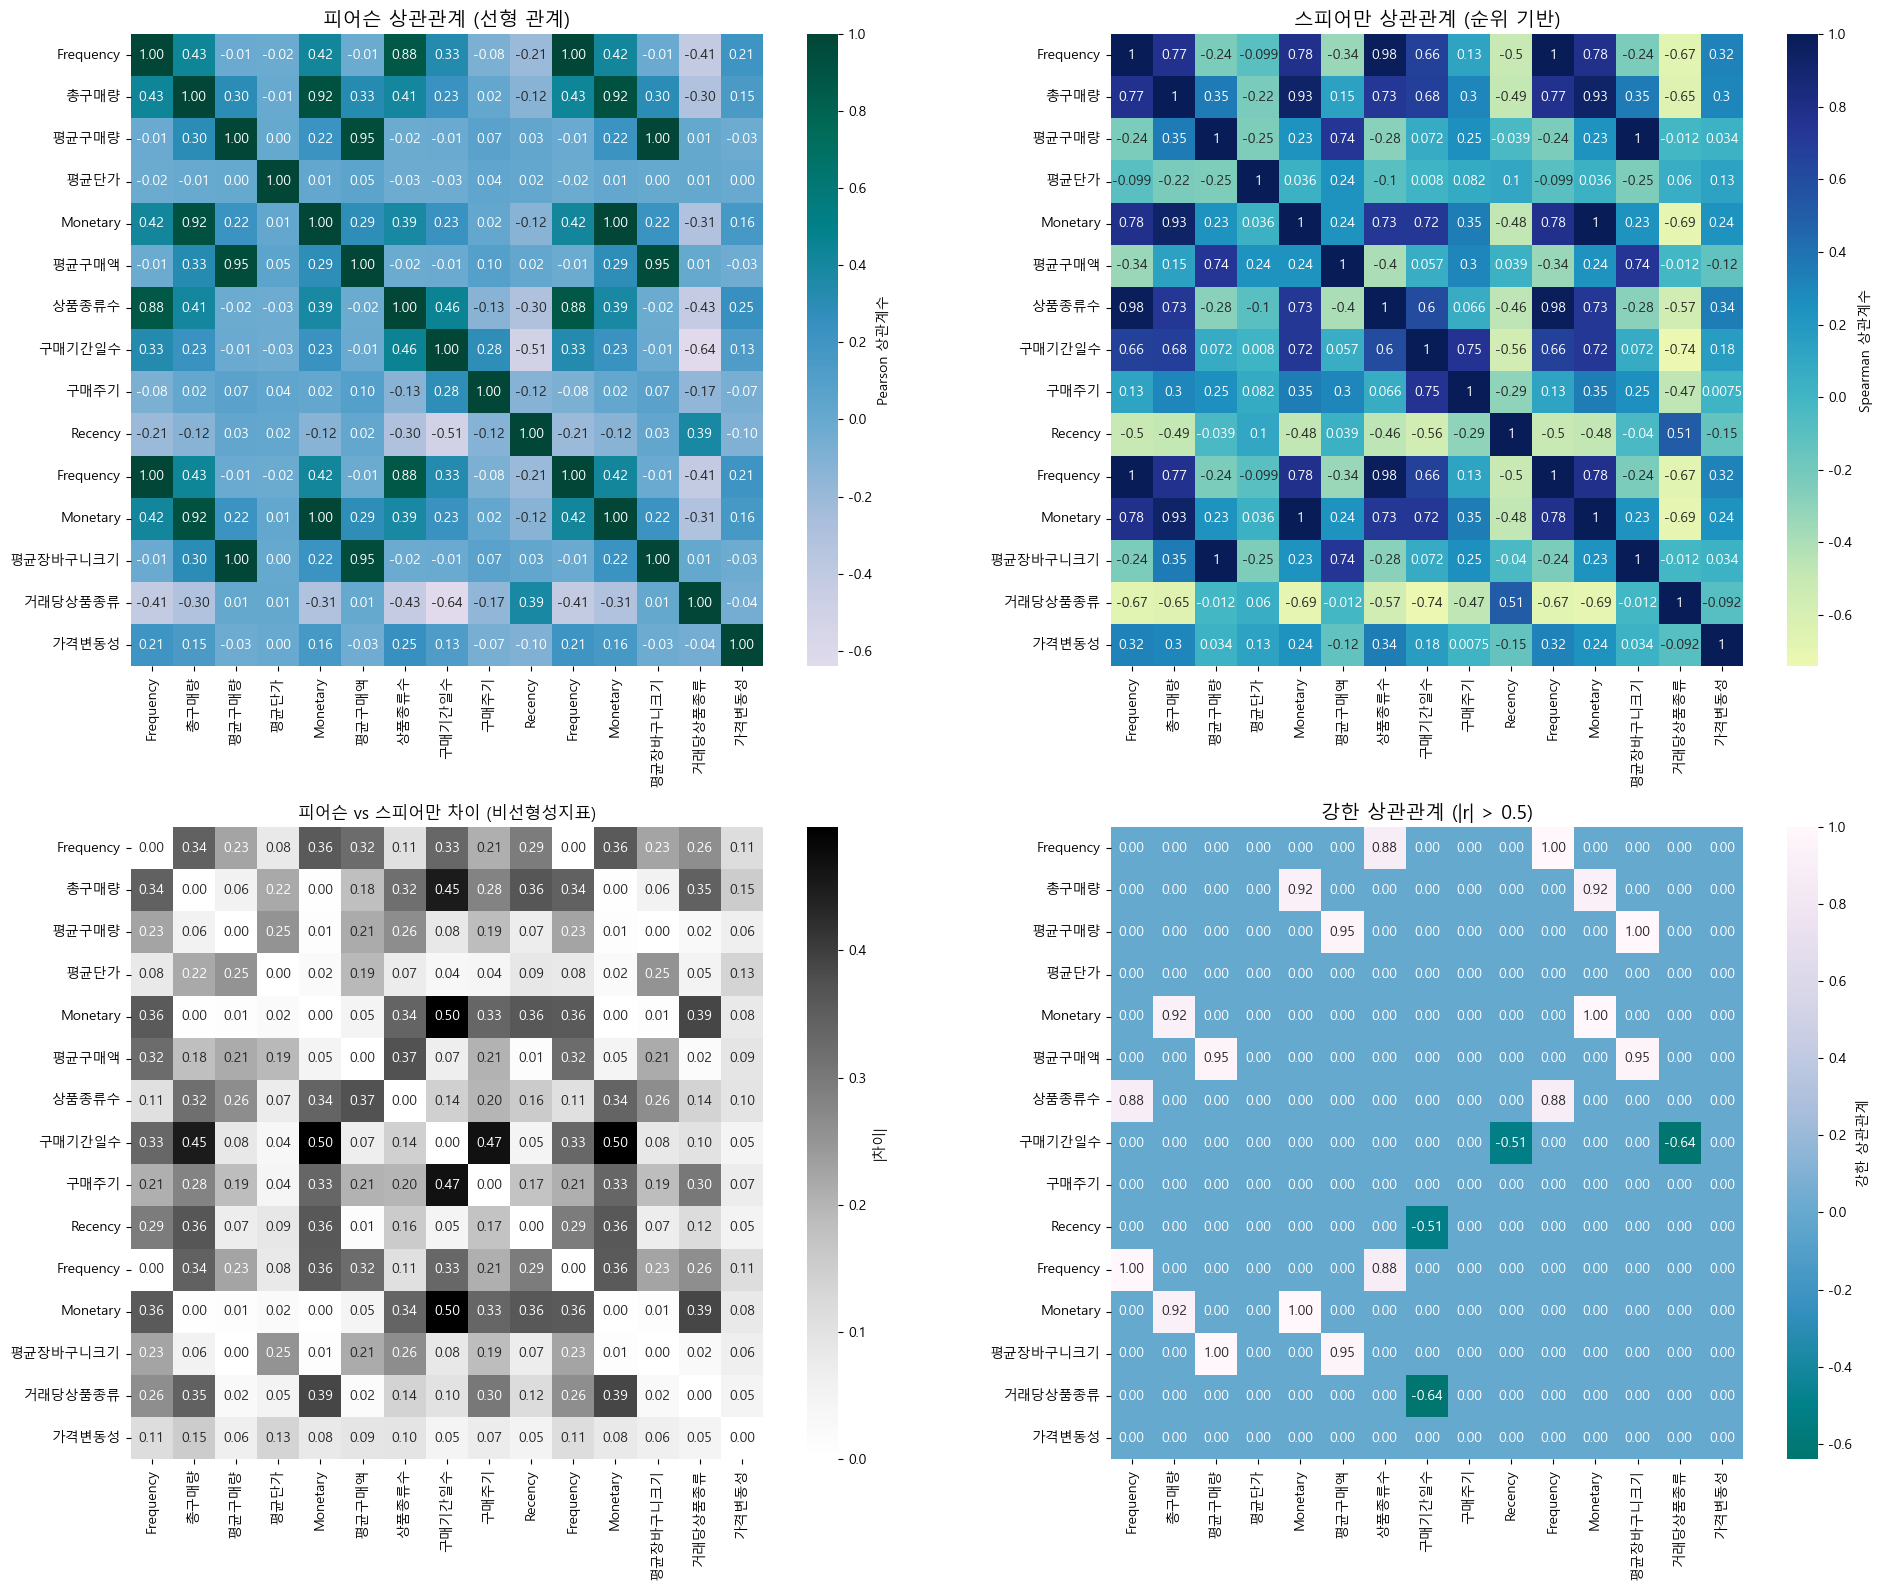

In [66]:
# 피어슨 상관관계 - 키<->몸무게 / 온도<->전력 같이 실제 값이 비례하는 경우 (값)
pearson_corr = correlation_data.corr(method='pearson')
# 스피어만 상관관계 - 시험순위<->대회순위 / 만족도<->재구매의사 같이 서열형 관계에 적합 (순서)
spearman_corr = correlation_data.corr(method='spearman')

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='PuBuGn', center=0, square=True, ax=a1, cbar_kws={'label': 'Pearson 상관계수'})
a1.set_title('피어슨 상관관계 (선형 관계)', fontsize=14)

sns.heatmap(spearman_corr, annot=True, cmap='YlGnBu', center=0, square=True, ax=a2, cbar_kws={'label': 'Spearman 상관계수'})
a2.set_title('스피어만 상관관계 (순위 기반)', fontsize=14)

corr_diff = abs(spearman_corr - pearson_corr)
sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='Greys', square=True, ax=a3, cbar_kws={'label': '|차이|'})
a3.set_title('피어슨 vs 스피어만 차이 (비선형성지표)')

# 강한 상관관계 (|r| > 0.5) 네트워크
strong_corr = pearson_corr.copy()
strong_corr[abs(strong_corr) < 0.5] = 0

np.fill_diagonal(strong_corr.values, 0)
sns.heatmap(strong_corr, annot=True, fmt='.2f', cmap='PuBuGn_r', center=0,
            square=True, ax=a4, cbar_kws={'label': '강한 상관관계'})
a4.set_title('강한 상관관계 (|r| > 0.5)', fontsize=14)

plt.tight_layout()
plt.show()